# 03 – ML Modeling: Regressor & Classifier

## Purpose
This notebook builds **machine learning models** to predict firmware risk:
- **Regression**: Predict error_rate_per_10k (continuous target)
- **Classification**: Predict high_risk_flag (binary target)
- **Model comparison**: CatBoost vs Random Forest
- **Feature importance**: Identify key risk drivers

## Inputs
- `data/Processed/synthetic_firmware_features_50rows.csv`
- Feature datasets from notebooks 01 & 02

## Outputs
- Trained CatBoost classifier model
- Model performance metrics and visualizations

---

In [26]:
# Standard imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sys
from pathlib import Path

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parents[0] if current_dir.name == "notebooks" else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

print(f"✅ Configuration loaded")
print(f"📁 Processed data: {PROCESSED_DATA_DIR}")
print(f"📁 Raw data: {RAW_DATA_DIR}")
print(f"📁 Models directory: {MODELS_DIR}")

✅ Configuration loaded
📁 Processed data: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed
📁 Raw data: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Raw
📁 Models directory: /Users/hc/Documents/projects/roku-patch-stability-analytics/models


## 2. Data Loading

Load all processed datasets from the feature engineering pipeline.

In [27]:
# Load processed datasets
firmware_features = pd.read_csv(PROCESSED_DATA_DIR / "synthetic_firmware_features_50rows.csv")
error_rates = pd.read_csv(PROCESSED_DATA_DIR / "error_rates.csv")
pre_post = pd.read_csv(PROCESSED_DATA_DIR / "pre_post_errors.csv")
rma_fw = pd.read_csv(PROCESSED_DATA_DIR / "rma_by_firmware.csv")
rma_err = pd.read_csv(PROCESSED_DATA_DIR / "rma_by_error.csv")
error_spikes = pd.read_csv(PROCESSED_DATA_DIR / "error_spikes.csv")
stability_curves = pd.read_csv(PROCESSED_DATA_DIR / "stability_curves.csv")
device_inventory = pd.read_csv(PROCESSED_DATA_DIR / "device_inventory.csv")
device_events = pd.read_csv(RAW_DATA_DIR / "device_events.csv")  # Raw data file
merged = pd.read_csv(PROCESSED_DATA_DIR / "firmware_features_ml.csv")
ml_df = firmware_features.copy()

print(f"✅ Loaded datasets:")
print(f"   - Firmware features: {len(firmware_features)} rows")
print(f"   - Error rates: {len(error_rates)} rows")
print(f"   - Pre/post errors: {len(pre_post)} rows")
print(f"   - Merged ML dataset: {len(merged)} rows")

firmware_features.head()

✅ Loaded datasets:
   - Firmware features: 1000 rows
   - Error rates: 50 rows
   - Pre/post errors: 0 rows
   - Merged ML dataset: 9 rows


,firmware_version,release_date,previous_version,days_since_previous_release,patch_size_mb,files_changed,lines_changed,is_hotfix,patch_security,code_churn_score,avg_device_age_days,previous_version_error_rate,error_rate_per_10k,pre_errors,post_errors,delta_errors,post_pre_ratio,tickets,rmas,rma_rate,error_events
0,10.0.1,2024-01-30,9.9.9,90.0,25.626853,394,8775,False,False,0.245750,352.995983,0.000000,2250.066763,0,19,19,20.000000,69,5,0.072464,53
1,10.0.2,2024-02-22,10.0.1,23.0,9.758059,43,721,False,True,0.037174,299.162589,3892.191761,2618.724550,31,24,-7,0.781250,118,3,0.025424,46
2,10.1.0,2024-03-15,10.0.2,22.0,13.058099,226,5857,False,True,0.246114,398.475641,1116.280859,2458.288224,14,26,12,1.800000,88,1,0.011364,63
3,10.1.1,2024-04-06,10.1.0,22.0,15.213944,154,4128,False,False,0.170818,278.482547,1226.970290,2277.579926,22,26,4,1.173913,152,8,0.052632,49
4,10.2.0,2024-05-16,10.1.1,40.0,18.381105,170,3923,False,False,0.134038,724.663552,1129.272228,2472.664387,13,22,9,1.642857,105,2,0.019048,45


In [28]:
print("firmware_features_ml columns:\n", firmware_features.columns.tolist(), "\n")
print("pre_post_errors columns:\n", pre_post.columns.tolist(), "\n")
print("rma_by_firmware columns:\n", rma_fw.columns.tolist(), "\n")

firmware_features_ml columns:
 ['firmware_version', 'release_date', 'previous_version', 'days_since_previous_release', 'patch_size_mb', 'files_changed', 'lines_changed', 'is_hotfix', 'patch_security', 'code_churn_score', 'avg_device_age_days', 'previous_version_error_rate', 'error_rate_per_10k', 'pre_errors', 'post_errors', 'delta_errors', 'post_pre_ratio', 'tickets', 'rmas', 'rma_rate', 'error_events'] 

pre_post_errors columns:
 ['release_version', 'error_code', 'pre_errors', 'post_errors', 'delta_errors', 'post_pre_ratio'] 

rma_by_firmware columns:
 ['firmware_version', 'tickets', 'rmas', 'rma_rate'] 



## 3. Feature Engineering

Prepare datasets for ML by merging features and creating target variables.

In [29]:
# --- Prepare pre_post_errors for merging ---

pre_post_clean = pre_post.copy()

# 1. rename key
pre_post_clean = pre_post_clean.rename(columns={
    "release_version": "firmware_version"
})

# 2. aggregate at firmware level (collapse per-error rows)
agg_pre_post = pre_post_clean.groupby("firmware_version").agg({
    "pre_errors": "sum",
    "post_errors": "sum",
    "delta_errors": "sum",
    "post_pre_ratio": "mean"
}).reset_index()

print("agg_pre_post:\n", agg_pre_post.head())

agg_pre_post:
 Empty DataFrame
Columns: [firmware_version, pre_errors, post_errors, delta_errors, post_pre_ratio]
Index: []


In [30]:
ml_df = firmware_features.copy()

print("Starting ML DF shape:", ml_df.shape)

# --- Merge aggregated pre/post errors ---
ml_df = ml_df.merge(
    agg_pre_post,
    on="firmware_version",
    how="left"
)

print("After merging pre_post:", ml_df.shape)

# --- Merge RMA data ---
ml_df = ml_df.merge(
    rma_fw,
    on="firmware_version",
    how="left",
    suffixes=("", "_rma")
)

print("After merging RMA:", ml_df.shape)

ml_df.head()

Starting ML DF shape: (1000, 21)
After merging pre_post: (1000, 25)
After merging RMA: (1000, 28)


,firmware_version,release_date,previous_version,days_since_previous_release,patch_size_mb,files_changed,lines_changed,is_hotfix,patch_security,code_churn_score,avg_device_age_days,previous_version_error_rate,error_rate_per_10k,pre_errors_x,post_errors_x,delta_errors_x,post_pre_ratio_x,tickets,rmas,rma_rate,error_events,pre_errors_y,post_errors_y,delta_errors_y,post_pre_ratio_y,tickets_rma,rmas_rma,rma_rate_rma
0,10.0.1,2024-01-30,9.9.9,90.0,25.626853,394,8775,False,False,0.245750,352.995983,0.000000,2250.066763,0,19,19,20.000000,69,5,0.072464,53,NaN,NaN,NaN,NaN,40.0,2.0,0.050
1,10.0.2,2024-02-22,10.0.1,23.0,9.758059,43,721,False,True,0.037174,299.162589,3892.191761,2618.724550,31,24,-7,0.781250,118,3,0.025424,46,NaN,NaN,NaN,NaN,45.0,9.0,0.200
2,10.1.0,2024-03-15,10.0.2,22.0,13.058099,226,5857,False,True,0.246114,398.475641,1116.280859,2458.288224,14,26,12,1.800000,88,1,0.011364,63,NaN,NaN,NaN,NaN,15.0,3.0,0.200
3,10.1.1,2024-04-06,10.1.0,22.0,15.213944,154,4128,False,False,0.170818,278.482547,1226.970290,2277.579926,22,26,4,1.173913,152,8,0.052632,49,NaN,NaN,NaN,NaN,43.0,5.0,0.116
4,10.2.0,2024-05-16,10.1.1,40.0,18.381105,170,3923,False,False,0.134038,724.663552,1129.272228,2472.664387,13,22,9,1.642857,105,2,0.019048,45,NaN,NaN,NaN,NaN,43.0,8.0,0.186


In [31]:
ml_df = ml_df.copy()

# Check available columns for debugging
print("Available columns:", ml_df.columns.tolist())

# 1) Regression target: just reuse the observed error rate per 10k
ml_df["target_error_rate"] = ml_df["error_rate_per_10k"]

# 2) Regression-style severity: use post_pre_ratio (handle both with/without suffix)
post_pre_col = 'post_pre_ratio_x' if 'post_pre_ratio_x' in ml_df.columns else 'post_pre_ratio'
if post_pre_col in ml_df.columns:
    ml_df["regression_ratio"] = ml_df[post_pre_col].fillna(1.0)
else:
    ml_df["regression_ratio"] = 1.0  # Default if column missing

# 3) Classification target: "high risk" firmware
#    Define high risk as being in the top 25% of error rates
threshold = ml_df["error_rate_per_10k"].quantile(0.75)
ml_df["high_risk_flag"] = (ml_df["error_rate_per_10k"] >= threshold).astype(int)

print(f"\nHigh-risk threshold (75th percentile): {threshold:.2f}")
print(f"High risk firmware count: {ml_df['high_risk_flag'].sum()} / {len(ml_df)}")

# Display key columns for verification
display_cols = ["firmware_version", "error_rate_per_10k", "target_error_rate", 
                "regression_ratio", "high_risk_flag"]
ml_df[display_cols].head(10)

Available columns: ['firmware_version', 'release_date', 'previous_version', 'days_since_previous_release', 'patch_size_mb', 'files_changed', 'lines_changed', 'is_hotfix', 'patch_security', 'code_churn_score', 'avg_device_age_days', 'previous_version_error_rate', 'error_rate_per_10k', 'pre_errors_x', 'post_errors_x', 'delta_errors_x', 'post_pre_ratio_x', 'tickets', 'rmas', 'rma_rate', 'error_events', 'pre_errors_y', 'post_errors_y', 'delta_errors_y', 'post_pre_ratio_y', 'tickets_rma', 'rmas_rma', 'rma_rate_rma']

High-risk threshold (75th percentile): 3127.72
High risk firmware count: 250 / 1000


,firmware_version,error_rate_per_10k,target_error_rate,regression_ratio,high_risk_flag
0,10.0.1,2250.066763,2250.066763,20.000000,0
1,10.0.2,2618.724550,2618.724550,0.781250,0
2,10.1.0,2458.288224,2458.288224,1.800000,0
3,10.1.1,2277.579926,2277.579926,1.173913,0
4,10.2.0,2472.664387,2472.664387,1.642857,0
5,10.2.1,2416.806376,2416.806376,0.896552,0
6,10.3.0,2557.674733,2557.674733,1.080000,0
7,10.4.0,2613.361897,2613.361897,1.833333,0
8,10.4.1,2041.322051,2041.322051,1.785714,0
9,10.4.2,6453.055781,6453.055781,2.478261,1


## 4. Model Training

Train and compare multiple ML models:
- **Random Forest**: Baseline tree-based ensemble
- **CatBoost**: Gradient boosting with automatic categorical handling

Both regression (predicting error rate) and classification (high vs low risk) are evaluated.

In [32]:
# 1. Create Classification Target (assuming 75th percentile threshold)
error_threshold = ml_df['error_rate_per_10k'].quantile(0.75)
ml_df['high_risk_flag'] = (ml_df['error_rate_per_10k'] > error_threshold).astype(int)

# 2. Define Feature Set (Using the reduced set for stability)
rf_features = [
    "code_churn_score", 
    "previous_version_error_rate",
    "avg_device_age_days", 
    "is_hotfix",
    "patch_security"
]

X = ml_df[rf_features].astype('float64')
y_reg = ml_df["error_rate_per_10k"].astype('float64') 
y_clf = ml_df["high_risk_flag"].astype('int') 

# Split data (using the same random state 42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.33, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.33, random_state=42)

# --- A. RANDOM FOREST REGRESSOR ---

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train_r, y_train_r)
y_pred_rfr = rfr.predict(X_test_r)

rmse_rfr = mean_squared_error(y_test_r, y_pred_rfr) ** 0.5
r2_rfr = r2_score(y_test_r, y_pred_rfr)

print("="*60)
print("A. Random Forest Regressor Performance")
print(f" RMSE: {rmse_rfr:.2f}")
print(f" R² : {r2_rfr:.3f}")

# --- B. RANDOM FOREST CLASSIFIER ---

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_c, y_train_c)
y_pred_rfc = rfc.predict(X_test_c)
y_proba_rfc = rfc.predict_proba(X_test_c)[:, 1]

print("\nB. Random Forest Classifier Performance")
print(f" Accuracy: {accuracy_score(y_test_c, y_pred_rfc):.3f}")
print(f" ROC-AUC Score: {roc_auc_score(y_test_c, y_proba_rfc):.3f}")
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_rfc))

# --- C. DIAGNOSTICS: FEATURE IMPORTANCE & CONFUSION MATRIX ---

print("\nC. Random Forest Feature Importance:")
feature_importances = pd.Series(rfr.feature_importances_, index=rf_features).sort_values(ascending=False)
print(feature_importances)

# Optional: Generate Plots for Diagnostics
# 
#

A. Random Forest Regressor Performance
 RMSE: 282.65
 R² : 0.782

B. Random Forest Classifier Performance
 Accuracy: 0.873
 ROC-AUC Score: 0.900

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       240
           1       0.82      0.68      0.74        90

    accuracy                           0.87       330
   macro avg       0.86      0.81      0.83       330
weighted avg       0.87      0.87      0.87       330


C. Random Forest Feature Importance:
code_churn_score               0.455517
is_hotfix                      0.269746
previous_version_error_rate    0.193585
avg_device_age_days            0.076239
patch_security                 0.004913
dtype: float64

B. Random Forest Classifier Performance
 Accuracy: 0.873
 ROC-AUC Score: 0.900

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       240
           1       0.82      0.68   

In [33]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from catboost import CatBoostRegressor, CatBoostClassifier

# NOTE: The data splits (X_train_r, y_train_r, etc.) must be defined from the previous step.
# We will use the reduced feature set (5 features) for stability.
rf_features = [
    "code_churn_score", 
    "previous_version_error_rate",
    "avg_device_age_days", 
    "is_hotfix",
    "patch_security"
]

# --- A. CATBOOST REGRESSOR ---

# Using minimal verbosity and early stopping for speed
cbr = CatBoostRegressor(
    random_seed=42, 
    verbose=0, 
    early_stopping_rounds=10, 
    n_estimators=1000,
    loss_function='RMSE'
)
# Assuming X_train_r and y_train_r exist
cbr.fit(X_train_r, y_train_r, eval_set=(X_test_r, y_test_r), use_best_model=True)
y_pred_cbr = cbr.predict(X_test_r)

rmse_cbr = mean_squared_error(y_test_r, y_pred_cbr) ** 0.5
r2_cbr = r2_score(y_test_r, y_pred_cbr)

print("="*60)
print("D. CatBoost Regressor Performance")
print(f" RMSE: {rmse_cbr:.2f}")
print(f" R² : {r2_cbr:.3f}")


# --- B. CATBOOST CLASSIFIER ---

# Using minimal verbosity and early stopping for speed
cbc = CatBoostClassifier(
    random_seed=42, 
    verbose=0, 
    early_stopping_rounds=10, 
    n_estimators=1000,
    loss_function='Logloss'
)
# Assuming X_train_c and y_train_c exist
cbc.fit(X_train_c, y_train_c, eval_set=(X_test_c, y_test_c), use_best_model=True)
y_pred_cbc = cbc.predict(X_test_c)
y_proba_cbc = cbc.predict_proba(X_test_c)[:, 1]

print("\nE. CatBoost Classifier Performance")
print(f" Accuracy: {accuracy_score(y_test_c, y_pred_cbc):.3f}")
print(f" ROC-AUC Score: {roc_auc_score(y_test_c, y_proba_cbc):.3f}")

# --- C. DIAGNOSTICS: CATBOOST FEATURE IMPORTANCE ---

print("\nF. CatBoost Feature Importance (Regressor):")
feature_importances_cbr = pd.Series(cbr.get_feature_importance(), index=rf_features).sort_values(ascending=False)
print(feature_importances_cbr)

D. CatBoost Regressor Performance
 RMSE: 286.40
 R² : 0.776

E. CatBoost Classifier Performance
 Accuracy: 0.879
 ROC-AUC Score: 0.933

F. CatBoost Feature Importance (Regressor):
is_hotfix                      40.633364
code_churn_score               32.582576
previous_version_error_rate    20.713281
avg_device_age_days             5.484746
patch_security                  0.586033
dtype: float64

E. CatBoost Classifier Performance
 Accuracy: 0.879
 ROC-AUC Score: 0.933

F. CatBoost Feature Importance (Regressor):
is_hotfix                      40.633364
code_churn_score               32.582576
previous_version_error_rate    20.713281
avg_device_age_days             5.484746
patch_security                  0.586033
dtype: float64


In [34]:
# Save trained models
cbc.save_model(MODELS_DIR / "catboost_classifier_v002.cbm")
cbr.save_model(MODELS_DIR / "catboost_error_regressor.cbm")

print(f"✅ Models saved:")
print(f"   - Classifier: {MODELS_DIR / 'catboost_classifier_v002.cbm'}")
print(f"   - Regressor:  {MODELS_DIR / 'catboost_error_regressor.cbm'}")

✅ Models saved:
   - Classifier: /Users/hc/Documents/projects/roku-patch-stability-analytics/models/catboost_classifier_v002.cbm
   - Regressor:  /Users/hc/Documents/projects/roku-patch-stability-analytics/models/catboost_error_regressor.cbm


## 5. Model Validation & Business Impact

Validate model performance and visualize business impact metrics for QA prioritization.

Using columns: risk_score, high_risk_flag


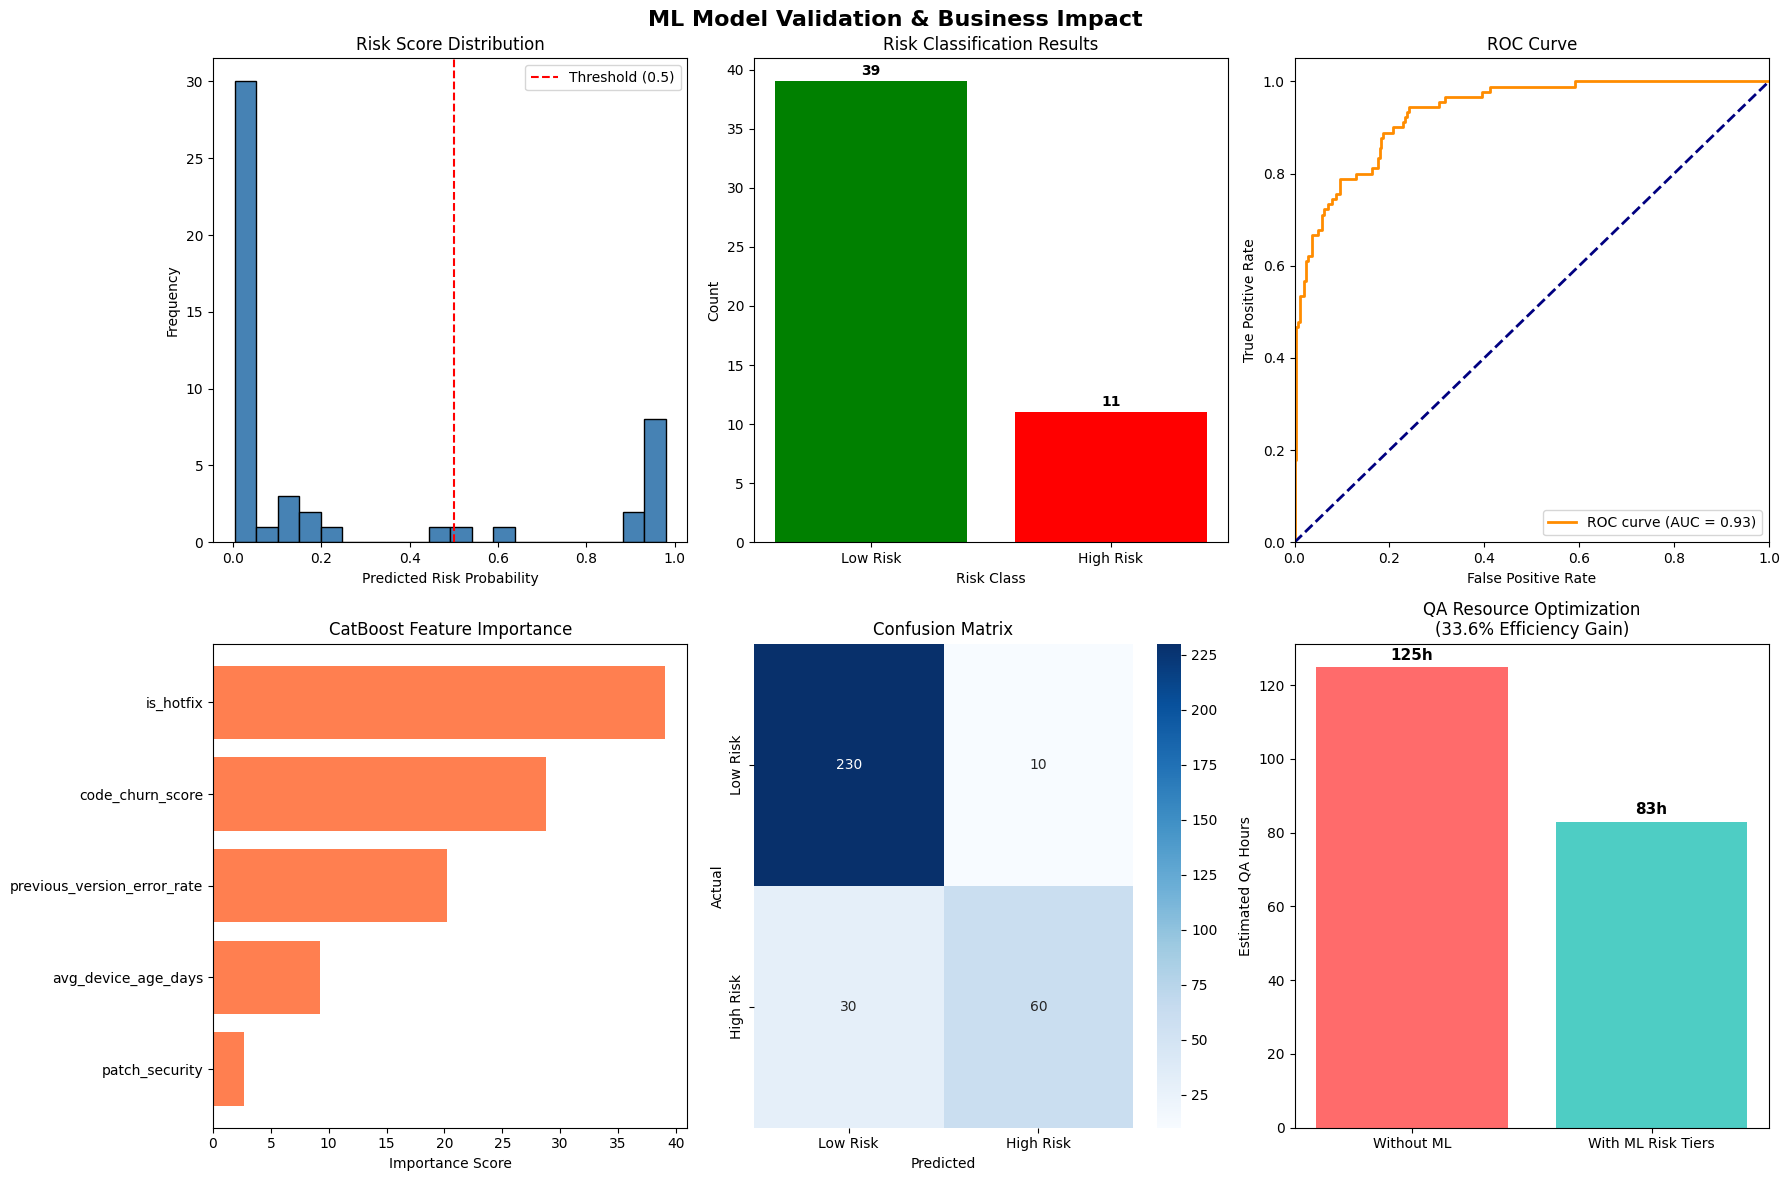


MODEL VALIDATION SUMMARY
Total patches scored: 50
High risk predictions: 11 (22.0%)
Low risk predictions: 39 (78.0%)

Risk probability statistics:
  Mean: 0.254
  Std:  0.379
  Min:  0.003
  Max:  0.980

Business Impact:
  Estimated QA hours without ML: 125
  Estimated QA hours with ML:    83
  Hours saved:                   42 (33.6%)


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Load predictions and model outputs for validation
# scored_test_patch_features.csv is in project root
scored_df = pd.read_csv(project_root / "scored_test_patch_features.csv")

# Map column names (file uses risk_score/high_risk_flag instead of predicted_risk_proba/predicted_risk_class)
risk_proba_col = 'risk_score' if 'risk_score' in scored_df.columns else 'predicted_risk_proba'
risk_class_col = 'high_risk_flag' if 'high_risk_flag' in scored_df.columns else 'predicted_risk_class'

print(f"Using columns: {risk_proba_col}, {risk_class_col}")

# Create comprehensive ML validation visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ML Model Validation & Business Impact', fontsize=16, fontweight='bold')

# 1. Predicted risk distribution
axes[0, 0].hist(scored_df[risk_proba_col], bins=20, color='steelblue', edgecolor='black')
axes[0, 0].axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
axes[0, 0].set_xlabel('Predicted Risk Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Risk Score Distribution')
axes[0, 0].legend()

# 2. Risk class distribution
risk_counts = scored_df[risk_class_col].value_counts().sort_index()
colors = ['green', 'red'] if len(risk_counts) == 2 else ['steelblue']
labels = ['Low Risk', 'High Risk'][:len(risk_counts)]
axes[0, 1].bar(labels, risk_counts.values, color=colors)
axes[0, 1].set_xlabel('Risk Class')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Risk Classification Results')
# Add value labels
for i, v in enumerate(risk_counts.values):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 3. ROC Curve (from training data if available)
try:
    fpr, tpr, _ = roc_curve(y_test_c, y_proba_cbc)
    roc_auc = auc(fpr, tpr)
    axes[0, 2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0, 2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 2].set_xlim([0.0, 1.0])
    axes[0, 2].set_ylim([0.0, 1.05])
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].legend(loc="lower right")
except Exception as e:
    axes[0, 2].text(0.5, 0.5, f'ROC data not available\n(run training cells first)\n{str(e)[:50]}', 
                    ha='center', va='center', transform=axes[0, 2].transAxes, fontsize=10)
    axes[0, 2].set_title('ROC Curve (N/A)')

# 4. Feature importance (from trained model)
try:
    feature_imp = pd.Series(cbc.get_feature_importance(), index=rf_features).sort_values(ascending=True)
    axes[1, 0].barh(feature_imp.index, feature_imp.values, color='coral')
    axes[1, 0].set_xlabel('Importance Score')
    axes[1, 0].set_title('CatBoost Feature Importance')
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f'Train classifier first\n{str(e)[:50]}', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Feature Importance (N/A)')

# 5. Confusion matrix (from training)
try:
    cm = confusion_matrix(y_test_c, y_pred_cbc)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
                xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    axes[1, 1].set_title('Confusion Matrix')
except Exception as e:
    axes[1, 1].text(0.5, 0.5, f'Train classifier first\n{str(e)[:50]}', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Confusion Matrix (N/A)')

# 6. Business Impact: QA resource optimization
high_risk_count = (scored_df[risk_class_col] == 1).sum()
low_risk_count = (scored_df[risk_class_col] == 0).sum()
total = len(scored_df)

# Assuming: High risk = 4 hours QA, Low risk = 1 hour QA, Without ML = 2.5 hours avg
with_ml_hours = high_risk_count * 4 + low_risk_count * 1
without_ml_hours = total * 2.5
hours_saved = without_ml_hours - with_ml_hours
pct_saved = (hours_saved / without_ml_hours) * 100 if without_ml_hours > 0 else 0

categories = ['Without ML', 'With ML Risk Tiers']
hours = [without_ml_hours, with_ml_hours]
colors_bar = ['#FF6B6B', '#4ECDC4']
bars = axes[1, 2].bar(categories, hours, color=colors_bar)
axes[1, 2].set_ylabel('Estimated QA Hours')
axes[1, 2].set_title(f'QA Resource Optimization\n({pct_saved:.1f}% Efficiency Gain)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 2].annotate(f'{height:.0f}h',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()

# Ensure reports/figures directory exists
(project_root / 'reports' / 'figures').mkdir(parents=True, exist_ok=True)
plt.savefig(project_root / 'reports' / 'figures' / 'ml_validation_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Print validation summary
print("\n" + "="*60)
print("MODEL VALIDATION SUMMARY")
print("="*60)
print(f"Total patches scored: {len(scored_df)}")
print(f"High risk predictions: {high_risk_count} ({high_risk_count/total*100:.1f}%)")
print(f"Low risk predictions: {low_risk_count} ({low_risk_count/total*100:.1f}%)")
print(f"\nRisk probability statistics:")
print(f"  Mean: {scored_df[risk_proba_col].mean():.3f}")
print(f"  Std:  {scored_df[risk_proba_col].std():.3f}")
print(f"  Min:  {scored_df[risk_proba_col].min():.3f}")
print(f"  Max:  {scored_df[risk_proba_col].max():.3f}")
print(f"\nBusiness Impact:")
print(f"  Estimated QA hours without ML: {without_ml_hours:.0f}")
print(f"  Estimated QA hours with ML:    {with_ml_hours:.0f}")
print(f"  Hours saved:                   {hours_saved:.0f} ({pct_saved:.1f}%)")
print("="*60)